In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch


from astropy.io import fits




In [2]:
# Assembly task
# https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/isrTask.py

from lsst.ip.isr.assembleCcdTask import (AssembleCcdConfig, AssembleCcdTask)
from lsst.ip.isr.isrTask import (IsrTask, IsrTaskConfig)

#https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/overscan.py
from lsst.ip.isr import  OverscanCorrectionTaskConfig, OverscanCorrectionTask

In [3]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
! eups list -s

afw                   g5b0a815229+07073039e0 	current w_2023_35 setup
alert_packet          gc1f99d08cb 	current w_2023_35 setup
analysis_drp          gfadca26dcd+7df23b908a 	current w_2023_35 setup
analysis_tools        g1887775915+12c68b5962 	current w_2023_35 setup
ap_association        g6758148a95+cc00875cc0 	current w_2023_35 setup
ap_pipe               g06c608b3b8+b6810408d8 	current w_2023_35 setup
ap_verify             g3bba7c13bf+c1b85e1378 	current w_2023_35 setup
astro_metadata_translator g0978aabd1f+2a7d2c9fe3 	current w_2023_35 setup
astshim               g3273194fdb+f6908454ef 	current w_2023_35 setup
atmospec              LOCAL:/home/m/monroy/repos/repos_w_2023_35/atmospec 	setup
base                  g98ffbb4407+81bc2a20b4 	current w_2023_35 setup
cbp                   ga32fcf49c8+ea6441928c 	current w_2023_35 setup
coadd_utils           g337abbeb29+ea6441928c 	current w_2023_35 setup
cp_pipe               g857a3418e4+7df23b908a 	current w_2023_35 setup
cp_verify       

# Butler 

In [6]:
import lsst.daf.butler as dafButler

In [7]:
embargo = True

In [8]:
if embargo:
    repo="/sdf/group/rubin/repo/oga/"
else:
    repo = "/sdf/group/rubin/repo/main"
butler = dafButler.Butler(repo)
registry = butler.registry

In [9]:
cameraName = 'LATISS'
calibCollections = ['LATISS/defaults','LATISS/raw/all']
for col in registry.queryCollections("*LATISS/calib*"):
    #print(col)
    calibCollections.append(col)

We check the different dimension records existing for *physical_filter*: 

In [10]:
phys_filters = list(registry.queryDimensionRecords('physical_filter',where="instrument='LATISS'"))

Print physical_filters with hologram in place: 

In [11]:
for f_ in phys_filters:
    if 'holo' in f_.name:
        print(f_.name)

empty~holo4_003
blank_bk7_wg05~holo4_003
KPNO_1111_436nm~holo4_003
KPNO_373A_677nm~holo4_003
KPNO_406_828nm~holo4_003
unknown~holo4_003
BG40~holo4_003
quadnotch1~holo4_003
RG610~holo4_003
FELH0600~holo4_003
SDSSg~holo4_003
SDSSr~holo4_003
SDSSi~holo4_003
BG40_65mm_1~holo4_003
BG40_65mm_2~holo4_003
OG550_65mm_1~holo4_003
OG550_65mm_2~holo4_003
SDSSg_65mm~holo4_003
SDSSr_65mm~holo4_003
SDSSi_65mm~holo4_003
SDSSu_65mm~holo4_003
SDSSz_65mm~holo4_003
SDSSy_65mm~holo4_003
empty~holo4_001
blank_bk7_wg05~holo4_001
KPNO_1111_436nm~holo4_001
KPNO_373A_677nm~holo4_001
KPNO_406_828nm~holo4_001
unknown~holo4_001
BG40~holo4_001
BG40_65mm_1~holo4_001
BG40_65mm_2~holo4_001
quadnotch1~holo4_001
RG610~holo4_001
OG550_65mm_1~holo4_001
OG550_65mm_2~holo4_001
FELH0600~holo4_001
SDSSg~holo4_001
SDSSr~holo4_001
SDSSi~holo4_001
SDSSu_65mm~holo4_001
SDSSg_65mm~holo4_001
SDSSr_65mm~holo4_001
SDSSi_65mm~holo4_001
SDSSz_65mm~holo4_001
SDSSy_65mm~holo4_001
collimator~holo4_003
collimator~holo4_001
cyl_lens~holo4_0

In [12]:
obs_type = 'science'
obs_day = 20230215
physical_filter = 'cyl_lens~holo4_003' #Note that there are no exposure with this config for the moment 

In [13]:
df_science = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num','time_start',
                                    'time_end' ,'type', 'target','filter_disp','zenith_angle',
                                    'expos','ra','dec','skyangle','science_program'])

In [14]:

#where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1} AND physical_filter='{2}'".format(obs_type,obs_day,physical_filter)
where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1}".format(obs_type,obs_day)
for i, info in enumerate(registry.queryDimensionRecords('exposure',where=where_exps)):
    
    #if info.observation_type=='science':
    id_ = info.id
    obs_id_ = info.obs_id
    day_obs_ = info.day_obs
    seq_num_ = info.seq_num
    timespan_ = info.timespan
    timespan_begin_ = pd.to_datetime(timespan_.begin.to_string())
    timespan_end_ = pd.to_datetime(timespan_.end.to_string())
    timespan_begin_jd_ = timespan_.begin.jd
    timespan_begin_mjd_ = timespan_.begin.mjd

    observation_type_ = info.observation_type
    target_name_ = info.target_name
    physical_filter_ = info.physical_filter
    zenith_angle_ = info.zenith_angle
    exposure_time_ = info.exposure_time
    tracking_ra_ = info.tracking_ra
    tracking_dec_ = info.tracking_dec
    sky_angle_ = info.sky_angle
    science_program_ = info.science_program

    df_science.loc[i] = [id_, obs_id_, day_obs_, seq_num_,timespan_begin_,timespan_end_ ,observation_type_, \
                         target_name_, physical_filter_, zenith_angle_, exposure_time_,tracking_ra_, \
                         tracking_dec_, sky_angle_, science_program_]

    if i < 2:
        print(i)
        print(info)
        print("\t timespan:            ",info.timespan)
        print("\t timespan.begin:      ",info.timespan.begin)
        print("\t id:                  ",info.id)
        print("\t day_obs:             ",info.day_obs)
        print("\t seq_num:             ",info.seq_num)
        print("\t type-of-observation: ",info.observation_type)
        print("\t target:              ",info.target_name)
        print("-----------------------------------------------------")
    

0
exposure:
  instrument: 'LATISS'
  id: 2023021500236
  physical_filter: 'SDSSr_65mm~empty'
  obs_id: 'AT_O_20230215_000236'
  exposure_time: 1.0
  dark_time: 1.2411
  observation_type: 'science'
  observation_reason: 'object'
  day_obs: 20230215
  seq_num: 236
  seq_start: 236
  seq_end: 236
  group_name: '2023-02-16T01:07:25.241'
  group_id: 2564392452410000
  target_name: 'HD25025'
  science_program: 'unknown'
  tracking_ra: 59.509266282087005
  tracking_dec: -13.505257465867974
  sky_angle: 214.8946079090418
  azimuth: 292.2695592645051
  zenith_angle: 34.101158096725364
  has_simulated: False
  timespan: Timespan(begin=astropy.time.Time('2023-02-16 01:07:35.505985', scale='tai', format='iso'), end=astropy.time.Time('2023-02-16 01:07:36.747000', scale='tai', format='iso'))
	 timespan:             [2023-02-16T01:07:35.505985, 2023-02-16T01:07:36.747000)
	 timespan.begin:       2023-02-16 01:07:35.505985
	 id:                   2023021500236
	 day_obs:              20230215
	 seq_nu

In [15]:
print('Number of entries = ',len(df_science))

Number of entries =  389


In [16]:
df_science.tail(5)

,id,obs_id,day_obs,seq_num,time_start,time_end,type,target,filter_disp,zenith_angle,expos,ra,dec,skyangle,science_program
384,2023021500755,AT_O_20230215_000755,20230215,755,2023-02-16 07:28:02.006997,2023-02-16 07:28:32.238,science,E5-A_010,SDSSi_65mm~empty,16.355978,30.0,180.595065,-45.784026,359.998518,AUXTEL_DRP_IMAGING
385,2023021500756,AT_O_20230215_000756,20230215,756,2023-02-16 07:28:46.502994,2023-02-16 07:29:16.734,science,E5-A_010,SDSSg_65mm~empty,16.401310,30.0,180.595023,-45.784011,359.998586,AUXTEL_DRP_IMAGING
386,2023021500757,AT_O_20230215_000757,20230215,757,2023-02-16 07:29:19.209998,2023-02-16 07:29:49.442,science,E5-A_010,SDSSg_65mm~empty,16.436042,30.0,180.595007,-45.783998,359.998518,AUXTEL_DRP_IMAGING
387,2023021500758,AT_O_20230215_000758,20230215,758,2023-02-16 07:30:04.856984,2023-02-16 07:30:35.099,science,E5-A_010,SDSSr_65mm~empty,16.485513,30.0,180.595036,-45.784002,359.998551,AUXTEL_DRP_IMAGING
388,2023021500759,AT_O_20230215_000759,20230215,759,2023-02-16 07:30:37.575012,2023-02-16 07:31:07.829,science,E5-A_010,SDSSr_65mm~empty,16.520654,30.0,180.595033,-45.784011,359.998568,AUXTEL_DRP_IMAGING


Select exposures: 

### For the moment, we take the sequence numnbers corresponding to the fits files that were given to us 

In [17]:
seq_nums = np.arange(276,281)
print(seq_nums)

[276 277 278 279 280]


We test retrieving one of them: 

In [19]:
seq_num0 = 279
exp_id0 = str(obs_day)+'00'+str(seq_num0)
exp_id0 = int(exp_id0)
print(exp_id0)

2023021500279


In [20]:
test_img = butler.get('raw', dataId={'exposure': exp_id0, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)

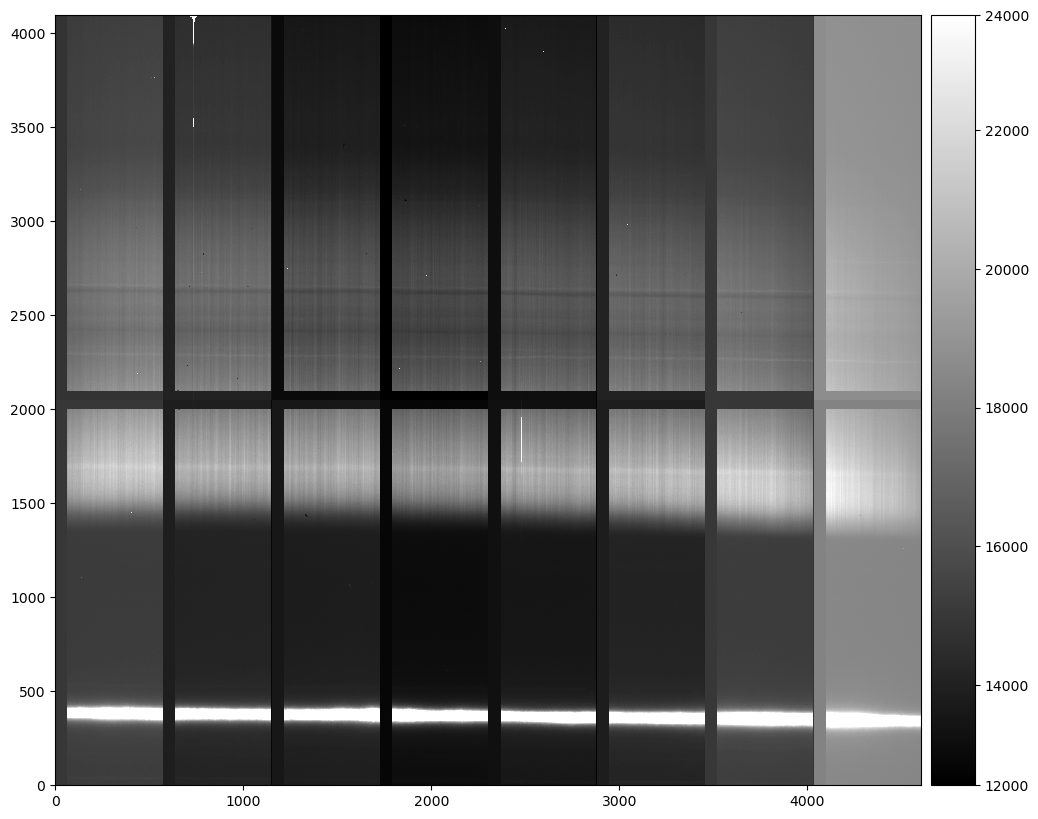

In [21]:
fig = plt.figure(figsize=(12,10))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('linear', 'zscale',None)
afw_display.mtv(test_img.image)

We do the ISR on this image the same way we do it with the spectra images (i.e., we do our pseudo-postISRCCD): 

In [22]:
# configuration
isr_config =  IsrTaskConfig()

In [23]:
isr_config.doDark = False
isr_config.doFlat =  False
isr_config.doFringe = False
isr_config.doDefect = True
isr_config.doLinearize = False
isr_config.doCrosstalk =  False
isr_config.doSaturationInterpolation = False
isr_config.overscan.fitType: 'MEDIAN_PER_ROW'
isr_config.doBias: True


In [24]:
isr_task = IsrTask(config=isr_config)

In [25]:
butler = dafButler.Butler(repo, collections=calibCollections)
camera = butler.get('camera', instrument=cameraName)
#bias = butler.get('bias',instrument=cameraName,detector=0)
#defects = butler.get('defects',instrument=cameraName,detector=0)

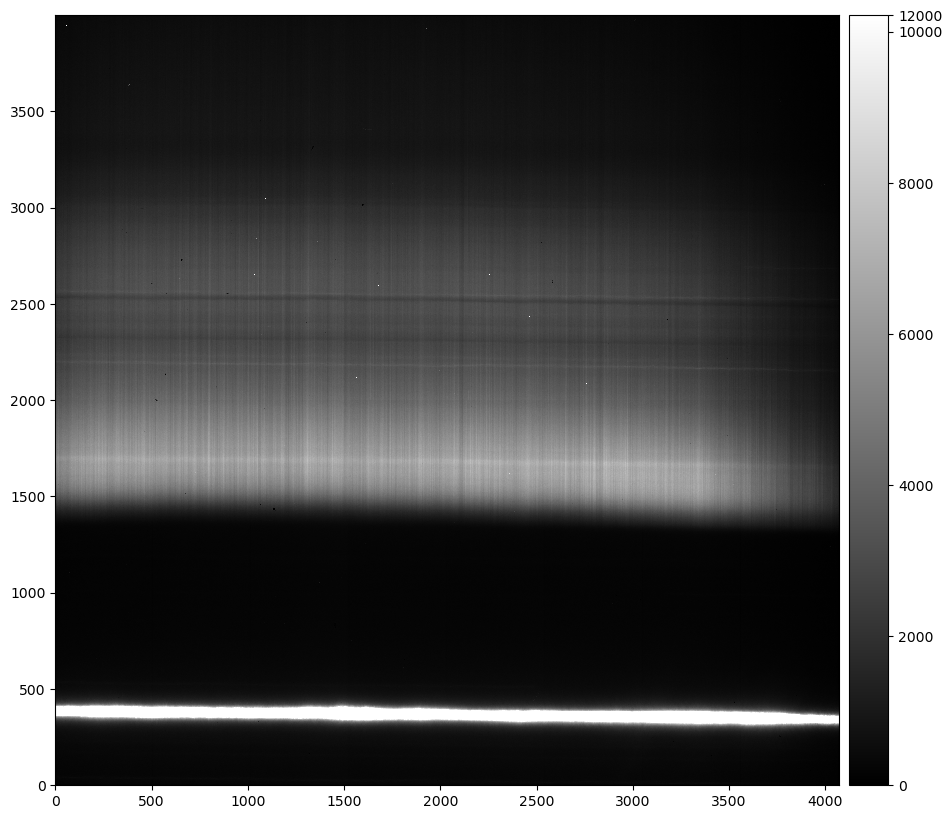

In [26]:

bias = butler.get("bias",instrument=cameraName, exposure= exp_id0, detector=0, collections=calibCollections)
defects = butler.get('defects',instrument=cameraName, exposure= exp_id0,detector=0,collections=calibCollections)

#fast ISR 
isr_test = isr_task.run(test_img,bias=bias,defects=defects)

%matplotlib inline

fig = plt.figure(figsize=(12,10))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('linear', 'zscale',None)
afw_display.mtv(isr_test.exposure.image)

Same plot but with matplotlib tools: 

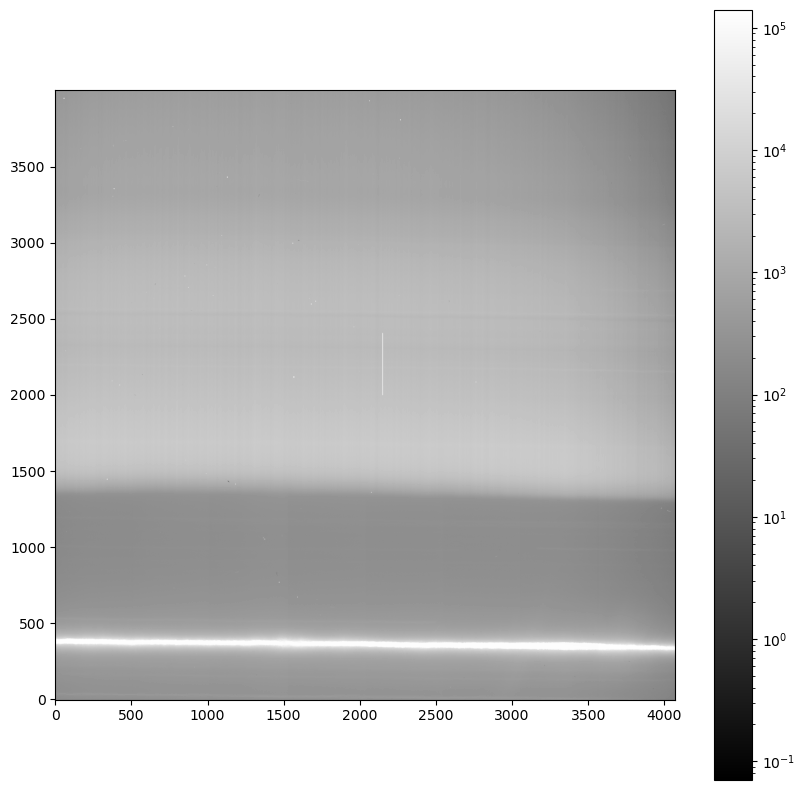

In [27]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow(isr_test.exposure.image.array,cmap="gray",origin='lower',norm=LogNorm())
fig.colorbar(im,ax=ax)

We rotate the image the same way we do with the spectra images: 

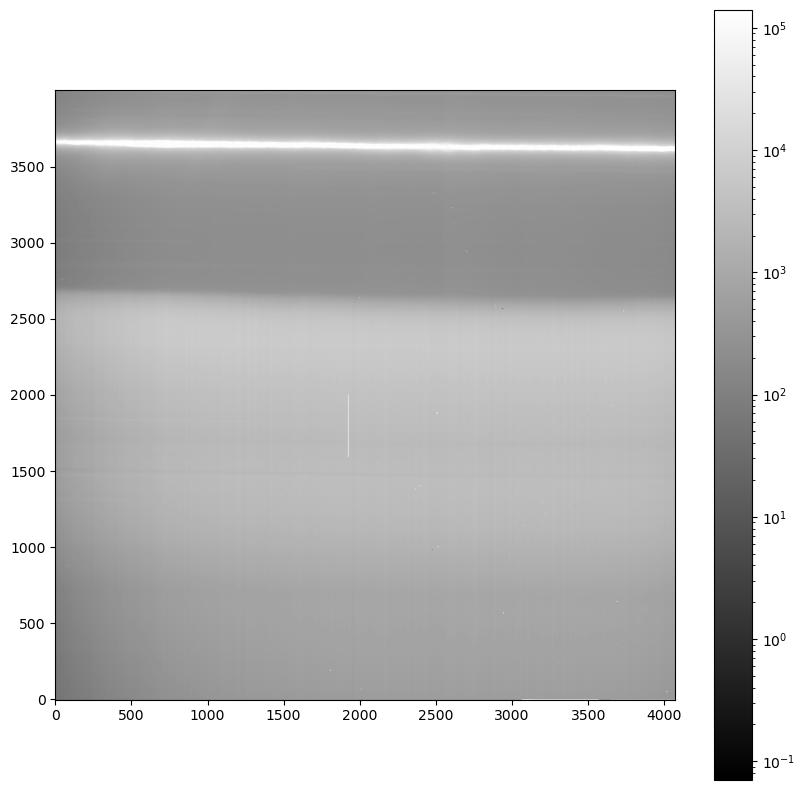

In [28]:
rotated_array = isr_test.exposure.image.array[::-1,::-1]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow(rotated_array,cmap="gray",origin='lower',norm=LogNorm())
fig.colorbar(im,ax=ax)

Now, we compare with the image that we were given in fits format: 

In [29]:
#image_path = '/sps/lsst/groups/auxtel/data/raw_ncsa/'+obs_date+'/'
image_path = './'
image_label = 'exposure_{0}_pseudo-postisrccd.fits'
image_name = os.path.join(image_path,image_label)
print(image_name)

./exposure_{0}_pseudo-postisrccd.fits


In [31]:
f0 = fits.open(image_name.format(exp_id0))

In [32]:
f0[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4072                                                  
NAXIS2  =                 4000                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               

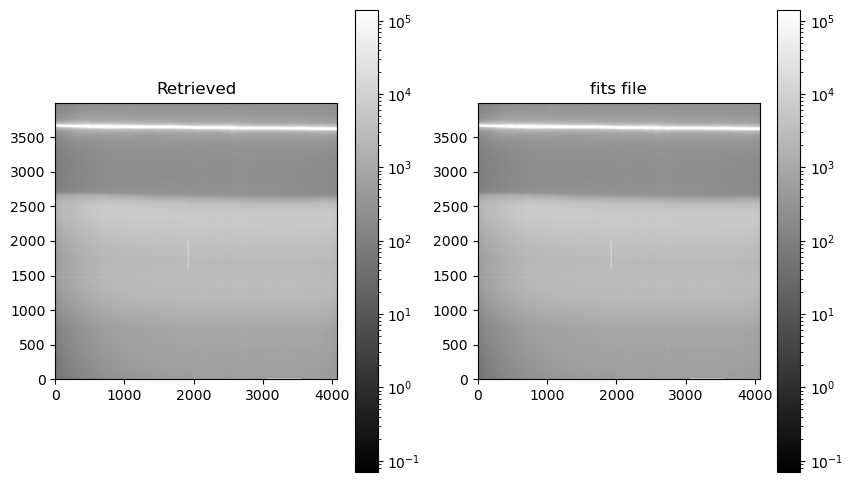

In [33]:
data0 = f0[1].data
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(121)
im = ax.imshow(rotated_array,cmap="gray",origin='lower',norm=LogNorm())
ax.set_title('Retrieved')
fig.colorbar(im,ax=ax)
ax = fig.add_subplot(122)
im = ax.imshow(data0,cmap="gray",origin='lower',norm=LogNorm())
ax.set_title('fits file')
fig.colorbar(im,ax=ax)

In [34]:
print(data0.shape)
print(type(data0))

(4000, 4072)
<class 'numpy.ndarray'>


# Create sum flat from individual flats 

In [35]:
print(seq_nums)

[276 277 278 279 280]


In [40]:
exp_list = []
for num_ in seq_nums:
    exp_id_ = str(obs_day)+'00'+str(num_)
    exp_id_ = int(exp_id_)
    print(exp_id_)
    raw_img_ = butler.get('raw', dataId={'exposure': exp_id_, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)
    print('Raw image retrieved')
    
    bias_ = butler.get("bias",instrument=cameraName, exposure= exp_id_, detector=0, collections=calibCollections)
    defects_ = butler.get('defects',instrument=cameraName, exposure= exp_id_,detector=0,collections=calibCollections)
    
    #fast ISR 
    print('Running pseudo-ISR')
    isr_img_ = isr_task.run(raw_img_,bias=bias_,defects=defects_)
    
    exp_list.append(isr_img_)
    print('-----------------')
    

2023021500276
Raw image retrieved
Running pseudo-ISR


-----------------
2023021500277
Raw image retrieved
Running pseudo-ISR


-----------------
2023021500278
Raw image retrieved
Running pseudo-ISR


-----------------
2023021500279
Raw image retrieved
Running pseudo-ISR


-----------------
2023021500280
Raw image retrieved
Running pseudo-ISR


-----------------


In [41]:
exp_list

[Struct(exposure=<lsst.afw.image._exposure.ExposureF object at 0x7efdbb514cf0>; ossThumb=None; flattenedThumb=None; outputBin1Exposure=None; outputBin2Exposure=None; preInterpExposure=None; outputExposure=<lsst.afw.image._exposure.ExposureF object at 0x7efdbb514cf0>; outputOssThumbnail=None; outputFlattenedThumbnail=None; outputStatistics=None),
 Struct(exposure=<lsst.afw.image._exposure.ExposureF object at 0x7efdbba06c30>; ossThumb=None; flattenedThumb=None; outputBin1Exposure=None; outputBin2Exposure=None; preInterpExposure=None; outputExposure=<lsst.afw.image._exposure.ExposureF object at 0x7efdbba06c30>; outputOssThumbnail=None; outputFlattenedThumbnail=None; outputStatistics=None),
 Struct(exposure=<lsst.afw.image._exposure.ExposureF object at 0x7efdbb335430>; ossThumb=None; flattenedThumb=None; outputBin1Exposure=None; outputBin2Exposure=None; preInterpExposure=None; outputExposure=<lsst.afw.image._exposure.ExposureF object at 0x7efdbb335430>; outputOssThumbnail=None; outputFlatt

In [44]:
test_flat = exp_list[0].exposure.image.array

In [34]:
data_vec = []
for ind_ in flats_ind:
    print(ind_)
    
    f_ = fits.open(image_name.format(ind_))
    data_ = f_[1].data
    data_vec.append(data_)
data_vec = np.array(data_vec)

276


FileNotFoundError: [Errno 2] No such file or directory: './exposure_2023021500276_pseudo-postisrccd.fits'

In [ ]:
print(data_vec.shape)

In [ ]:
data_sum = np.sum(data_vec,axis=0)

In [ ]:
(data_sum==data_vec).all()

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#im = ax.imshow(data_sum,cmap="gray",vmin=0.,vmax=4e4)
im = ax.imshow(data_sum,cmap="gray",origin='lower',norm=LogNorm())
fig.colorbar(im,ax=ax)

In [ ]:
_ = plt.hist(data_sum[:3500,:].ravel(),bins=100)#,range=(0.8,1.2))
plt.xscale("log")

In [ ]:
new_hdul = fits.HDUList()
hdu1 = fits.PrimaryHDU()
hdu2 = fits.ImageHDU()

hdu1.header = f0[0].header
hdu1.data = f0[0].data

hdu2.header = f0[1].header
hdu2.data = data_sum

new_hdul.append(hdu1)
new_hdul.append(hdu2)


new_hdul.writeto('1d_flat.fits', overwrite=True)

In [ ]:
data_sub = data_sum[:,1500:1900]

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#im = ax.imshow(data_sub,cmap="gray",vmin=0.,vmax=4e4)
im = ax.imshow(data_sub,cmap="gray",origin='lower',norm=LogNorm())
fig.colorbar(im,ax=ax)

In [ ]:
print(data_sub.shape)

In [ ]:
data_sub_proj = np.mean(data_sub,axis=1)

In [ ]:
print(data_sub_proj.shape)

In [ ]:
data_sub_norm = []
for i in range(len(data_sub[:,0])):
    data_sub_norm.append(np.array(data_sub[i,:]/data_sub_proj[i]))
    #print(data_sub[i:]/data_sub_proj[i])

In [ ]:
data_sub_norm = np.array(data_sub_norm)
print(data_sub_norm.shape)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow(data_sub_norm,origin='lower',cmap="gray",vmin=8e-1,vmax=1.2)
#im = ax.imshow(data_sub_norm,origin='lower',cmap="gray",norm=LogNorm())#,vmin=9.5e-1,vmax=1.05)
fig.colorbar(im,ax=ax)

In [ ]:
_ = plt.hist(data_sub_norm.ravel(),bins=100)#,range=(0.8,1.2))
plt.xscale("log")

In [ ]:
data_sum_norm = []
for i in range(len(data_sum[:,0])):
    if i<3500:
        data_sum_norm.append(np.array(data_sum[i,:]/data_sub_proj[i]))
    else:
        data_sum_norm.append(np.zeros(len(data_sum[i,:])))

In [ ]:
data_sum_norm = np.array(data_sum_norm)
print(data_sum_norm.shape)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow(data_sum_norm,cmap="gray",origin='lower',vmin=8.0e-1,vmax=1.2)
fig.colorbar(im,ax=ax)

In [ ]:
new_hdul = fits.HDUList()
hdu1 = fits.PrimaryHDU()
hdu2 = fits.ImageHDU()

hdu1.header = f0[0].header
hdu1.data = f0[0].data

hdu2.header = f0[1].header
hdu2.data = data_sum_norm

new_hdul.append(hdu1)
new_hdul.append(hdu2)


new_hdul.writeto('1d_flat_normalized.fits', overwrite=True)

In [ ]:
data_vec2 = []
for ind_ in flats_ind[1:]:
    print(ind_)
    
    f_ = fits.open(image_name.format(ind_))
    data_ = f_[1].data
    data_vec2.append(data_)
data_vec2 = np.array(data_vec2)

In [ ]:
data_sum2 = np.sum(data_vec2,axis=0)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
im = ax.imshow(data_sum2,cmap="gray",vmin=0.,vmax=3e4)
fig.colorbar(im,ax=ax)

In [ ]:
_ = plt.hist(data_sum2.ravel(),bins=100)#,range=(0.8,1.2))
plt.xscale("log")